# Credits

This is heavily influenced from https://github.com/pytorch/tutorials

# CIFAR-10

In thins notebook you need to put what you have learned into practice, and create your own convolutional classifier for the CIFAR-10 dataset.

It has the classes: ‘airplane’, ‘automobile’, ‘bird’, ‘cat’, ‘deer’, ‘dog’, ‘frog’, ‘horse’, ‘ship’, ‘truck’.
The images in CIFAR-10 are of size 3x32x32, i.e. 3-channel color images of 32x32 pixels in size.

![cifar10](https://github.com/DeepLearningDTU/02456-deep-learning-with-PyTorch/blob/master/static_files/cifar10.png?raw=1)


In order to train a classifier the following steps needs to be performed:

1. Load and normalizing the CIFAR10 training and test datasets using
   ``torchvision``
2. Define a Convolutional Neural Network
3. Define a loss function
4. Train the network on the training data
5. Test the network on the test data

We will help you along the way.
We indicate the places you need to modify the code with `# Your code here!`.
It is however a good idea to read the entire assignment before you begin coding!

## 1. Loading and normalizing CIFAR10

Using ``torchvision``, it’s extremely easy to load CIFAR10.

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import torch
import torchvision
import torchvision.transforms as transforms

The output of torchvision datasets are PILImage images of range [0, 1].
We transform them to Tensors of normalized range [-1, 1]

**NB** Modify the code below to only use a small part of the dataset if your computer is very slow.

In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5),(0.5, 0.5, 0.5))
    ]
)

# Load dataset
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

used_categories = range(len(classes))

## USE CODE BELOW IF YOUR COMPUTER IS TOO SLOW
"""
reduce_dataset = True
if reduce_dataset:
    used_categories = (3, 5) # cats and dogs

    classes = [classes[i] for i in used_categories]
    new_train_data = []
    new_train_labels = []

    new_test_data = []
    new_test_labels = []
    for i, t in enumerate(used_categories):
        new_train_data.append(trainset.data[np.where(np.array(trainset.targets) == t)])
        new_train_labels += [i for _ in range(new_train_data[-1].shape[0])]

        new_test_data.append(testset.data[np.where(np.array(testset.targets) == t)])
        new_test_labels += [i for _ in range(new_test_data[-1].shape[0])]

    new_train_data = np.concatenate(new_train_data, 0)
    trainset.data = new_train_data
    trainset.targets = new_train_labels

    new_test_data = np.concatenate(new_test_data, 0)
    testset.data = new_test_data
    testset.targets = new_test_labels
"""
    
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=True, num_workers=2)
train_data_iter = iter(trainloader)
test_data_iter = iter(testloader)
print('used classes:', classes)

Files already downloaded and verified
Files already downloaded and verified
used classes: ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


In [ ]:
print("# Training data")
print("Number of points:", len(trainset))
x, y = next(iter(trainloader))
print("Batch dimension [B x C x H x W]:", x.shape)
print("Number of distinct labels:", len(set(trainset.targets)))


print("\n# Test data")
print("Number of points:", len(testset))
x, y = next(iter(testloader))
print("Batch dimension [B x C x H x W]:", x.shape)
print("Number of distinct labels:", len(set(testset.targets)))

# Training data
Number of points: 50000
Batch dimension [B x C x H x W]: torch.Size([4, 3, 32, 32])
Number of distinct labels: 10

# Test data
Number of points: 10000
Batch dimension [B x C x H x W]: torch.Size([4, 3, 32, 32])
Number of distinct labels: 10


Let us show some of the training images, for fun.



horse   dog horse  frog


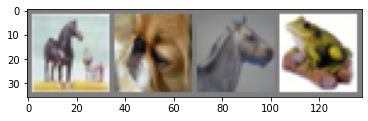

In [ ]:
# Run this cell multiple time to see more samples

def imshow(img):
    """ show an image """
    img = img / 2 + 0.5 # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
images, labels = train_data_iter.next()

# show images
imshow(torchvision.utils.make_grid(images))

# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

## 2. Define a Convolutional Neural Network

**Assignment 1:** Define a convolutional neural network. 
You may use the code from previous notebooks.
We suggest that you start with a small network, and make sure that everything is working.
Once you can train successfully come back and improve the architecture

In [ ]:
from torch.autograd import Variable
import torch.nn as nn
from torch.nn import Linear, Conv2d, BatchNorm2d, MaxPool2d, Dropout2d
from torch.nn.functional import relu, softmax

# Hyperameters of the model
num_classes = 10
x, y = next(iter(trainloader))
channels = x.shape[1]
height = x.shape[2]
width = x.shape[3]
num_filters_conv1 = 16
kernel_size_conv1 = 5 
stride_conv1 = 1
num_l1 = 200
padding_conv1 = 0
dropout = 0.3
   
def compute_conv_dim(dim_size):
    return int((dim_size - kernel_size_conv1 + 2 * padding_conv1) / stride_conv1 + 1)

# Define network
class Net(nn.Module):

    def __init__(self, num_classes):
        super(Net, self).__init__()
        self.num_classes = num_classes
        self.conv_1 = Conv2d(in_channels=channels,
                             out_channels=num_filters_conv1,
                             kernel_size=kernel_size_conv1,
                             stride=stride_conv1)
        
        self.conv_out_height = compute_conv_dim(height)
        self.conv_out_width = compute_conv_dim(width)
        self.dropout = Dropout2d(p=dropout)
        self.l1_in_features = num_filters_conv1 * self.conv_out_height * self.conv_out_width
        self.l_1 = Linear(in_features=self.l1_in_features, 
                          out_features=num_l1,
                          bias=True)
        self.l_out = Linear(in_features=num_l1, 
                            out_features=num_classes,
                            bias=False)
    
    def forward(self, x): # x.size() = [batch, channel, height, width]
        x = relu(self.conv_1(x))
        x = x.view(-1, self.l1_in_features)
        x = relu(self.l_1(x))
        x = self.dropout(x)
        x = self.l_out(x)
        x = softmax(x, dim=1)
        return x

net = Net(len(used_categories))
print(net)

Net(
  (conv_1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1))
  (dropout): Dropout2d(p=0.3, inplace=False)
  (l_1): Linear(in_features=12544, out_features=200, bias=True)
  (l_out): Linear(in_features=200, out_features=10, bias=False)
)


## 3. Define a Loss function and optimizer

**Assignment 2:** Implement the criterion and optimizer. 
We suggest Classification Cross-Entropy loss and SGD with momentum.
You might need to experiment a bit with the learning rate.

In [ ]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

## 4. Train the network

**Assignment 3:** Finish the training loop below. 
Start by using a small number of epochs (e.g. 3).
Even with a low number of epochs you should be able to see results that are better than chance.
When everything is working increase the number of epochs to find out how good your network really is.

In [ ]:
num_epoch = 3

for epoch in range(num_epoch):  # Loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # Get the inputs
        inputs, labels = data

        # Wrap them in Variable
        inputs, labels = Variable(inputs), Variable(labels)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward + backward + optimize
        output = net(inputs)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()

        # Print statistics
        running_loss += loss.item()
        if i % 1000 == 999:    # print every 1000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 1000))
            running_loss = 0.0

print('Finished Training')

[1,  1000] loss: 2.262
[1,  2000] loss: 2.181
[1,  3000] loss: 2.160
[1,  4000] loss: 2.124
[1,  5000] loss: 2.112
[1,  6000] loss: 2.101
[1,  7000] loss: 2.097
[1,  8000] loss: 2.071
[1,  9000] loss: 2.078
[1, 10000] loss: 2.072
[1, 11000] loss: 2.062
[1, 12000] loss: 2.057
[2,  1000] loss: 2.036
[2,  2000] loss: 2.035
[2,  3000] loss: 2.028
[2,  4000] loss: 2.019
[2,  5000] loss: 2.024
[2,  6000] loss: 2.016
[2,  7000] loss: 2.017
[2,  8000] loss: 2.004
[2,  9000] loss: 2.013
[2, 10000] loss: 2.009
[2, 11000] loss: 2.010
[2, 12000] loss: 2.006
[3,  1000] loss: 1.977
[3,  2000] loss: 1.984
[3,  3000] loss: 1.988
[3,  4000] loss: 1.988
[3,  5000] loss: 1.978
[3,  6000] loss: 1.977
[3,  7000] loss: 1.978
[3,  8000] loss: 1.977
[3,  9000] loss: 1.973
[3, 10000] loss: 1.971
[3, 11000] loss: 1.967
[3, 12000] loss: 1.980
Finished Training


## 5. Test the network on the test data

Now we need to check if the network has learnt anything at all.
We will check this by predicting the class label that the neural network outputs, and checking it against the ground truth.
If the prediction is correct, we add the sample to the list of correct predictions.

Okay, first step. Let us display an image from the test set to get familiar.

In [ ]:
images, labels = test_data_iter.next()
# 
# print images
imshow(torchvision.utils.make_grid(images))
plt.show()

print('GroundTruth:  ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

outputs = net(images)
_, predicted = torch.max(outputs.data, 1)
print('Predicted:    ', ' '.join('%5s' % classes[predicted[j]] for j in range(4)))

<font color="blue"> Couldn't figure out how to resolve an error that occurred in the code block above :(

Let us look at how the network performs on the whole dataset.

In [ ]:
correct = 0
total = 0

for data in testloader:
    images, labels = data
    outputs = net(Variable(images))
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum()

print('Accuracy of the network on the {} test images: {:4.2f} %'.format(
    testset.data.shape[0], 100 * correct.true_divide(total)))

Accuracy of the network on the 10000 test images: 49.21 %


Hopefully the network is better than chance, which is $\frac{1}{\text{number of classes}}$ accuracy (randomly picking
a class).

We can also examine which class the network found the most difficult (makes more sense if you have many clases):

In [ ]:
class_total = list(0. for i in range(len(classes)))
class_correct = list(0. for i in range(len(classes)))

for data in testloader:
    images, labels = data
    outputs = net(Variable(images))
    _, predicted = torch.max(outputs.data, 1)
    c = (predicted == labels).squeeze()
    
    for i in range(len(c)):
        label = labels[i]
        class_correct[label] += c[i].numpy()
        class_total[label] += 1

for i in range(len(classes)):
    print('Accuracy of {:5s} : {:5.2f} %'.format(
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 59.30 %
Accuracy of car   : 59.70 %
Accuracy of bird  : 35.50 %
Accuracy of cat   : 35.90 %
Accuracy of deer  : 38.20 %
Accuracy of dog   : 42.40 %
Accuracy of frog  : 54.50 %
Accuracy of horse : 60.10 %
Accuracy of ship  : 60.10 %
Accuracy of truck : 51.00 %


**Assignment 4:** 
1. Go back and improve performance of the network. 
 * If you are using all 10 classes you should get a test accuracy above 55%, but see how much further you can get it!
 * If you are using only 2 classes (e.g. cat and dog) you should get a test accuracy above 60%, but see how much further you can get it!

2. Briefly describe what you did and any experiments you did along the way as well as what results you obtained.
Did anything surprise you during the exercise?

3. Write down key lessons/insights you got (if any) during this exercise.

**Answer:**

<font color="blue"> I'm using all 10 classes.

<font color="blue"> **My initial, simple network** consisted of one hidden layer (input -> one hidden layer -> output) with 100 hidden units. Used ReLu on the hidden layer and softmax on the output layer (taken from lab 4.1). Criterion was cross entropy loss and optimizer was SGD with a learning rate of 0.01 and momentum of 0.9. Three epochs. Accuracy of 10,000 test images was 30.58% which is better than chance (1/10 = 0.1). Highest accuracy was truck (65.40%) and lowest was cat (0.00%). 

<font color="blue"> **Second try.** I added all the convolutional parameters to the network, still just one hidden layer. I increased the hidden units in that layer from 100 to 200. I also added dropout of 30% after the hidden layer but still used ReLu and softmax as before. Then I decreased the learning rate of the optimizer to 0.001. Still had only three epochs. This resulted in the accuracy score of the 10,000 test images being 49.21%. Now the highest accuracy was horse and ship (60.10%) and lowest was bird (35.50%). So, we see quite an improvement here from the first try. 

**Further...** I was trying to improve more but ran out of time :/</font>

# Training on GPU

**Optional Assignment:**
If you have a GPU we suggest that you try and rewrite the code above to run on the GPU
___

Just like how you transfer a Tensor on to the GPU, you transfer the neural net onto the GPU.
This will recursively go over all modules and convert their parameters and buffers to CUDA tensors:

```
    net.cuda()
```

Remember that you will have to send the inputs and targets at every step to the GPU too:

```
    inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
```

Why dont I notice MASSIVE speedup compared to CPU? 
Because your network is realllly small.

**Exercise:** Try increasing the width of your network (argument 2 of
the first ``nn.Conv2d``, and argument 1 of the second ``nn.Conv2d`` –
they need to be the same number), see what kind of speedup you get.

**Goals achieved**:

- Understanding PyTorch's Tensor library and neural networks at a high level.
- Train a small neural network to classify images

## Setting up GPU in Colab

In Colab, you will get 12 hours of execution time but the session will be disconnected if you are idle for more than 60 minutes. It means that for every 12 hours Disk, RAM, CPU Cache and the Data that is on our allocated virtual machine will get erased.

To enable GPU hardware accelerator, just go to **Runtime -> Change runtime type -> Hardware accelerator -> GPU**

# Michael Nielsen book exercise of own choice

**Assignment 5:** Pick an exercise of own choice from [Michael Nielsens book](http://neuralnetworksanddeeplearning.com/)

**Answer:**

### Exercise 3.2 in chapter 1 of "Neural Networks and Deep Learning"

I explained gradient descent when $C$ is a function of two variables, and when it's a function of more than two variables. What happens when $C$ is a function of just one variable? Can you provide a geometric interpretation of what gradient descent is doing in the one-dimensional case?

**Solution:**

When $C$ is a function of just one variable, the gradient of $C$ is simply differentation w.r.t. the one variable. Now, gradient descent looks to find the global minimum of a function (for optimization). This is also the case for a one-dimensional function. The image below (taken from this [towards data science article](https://towardsdatascience.com/stochastic-gradient-descent-explained-in-real-life-predicting-your-pizzas-cooking-time-b7639d5e6a32)) clearly shows what's happening in gradient descent in one dimension. We start by picking a random point, being the dark green one in the image. We then compute the negative gradient at that point. We update our initial point with our results and then iterate through these steps again and again until our gradient/differentation becomes zero - then we've found the minumum!

Just as with gradient descent in more than one dimensions, we can always face the danger of entering a local minima instead of the global one, given that the functions has more than one minima (unlike the one on the image below).

![grad1d](https://miro.medium.com/max/1400/1*sUj0ZEau1ooTNg6bnYlebg.png)





# <font color="red"> Solutions from Peergrade feedback notebooks

### <font color="red"> Peergrade submission 1

<font color="red"> In this assignment, drop outing method, adam optimizer, L2 regularization were used, and as it can be seen in below, classification accuracy increased in one category (dog), but in another category, the accuracy decreased. 
I expect with increasing the number of epoches and training data, accuracy and performance of the model will increase. 

In [ ]:

# add dropout
# using adam optimizer
# using L2 regularization
# increase the number of epoch

class Net(nn.Module):
    def __init__(self, num_classes):
        super(Net, self).__init__()
        self.num_classes = num_classes
        
        # Your code here!

        self.conv1 = nn.Conv2d(3, 6, 5, stride=(1, 1))
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

        self.fc1 = nn.Linear(16 * 5 * 5, 300)
        self.fc2 = nn.Linear(300, 120)
        self.fc3 = nn.Linear(120, 84)
        self.fc4 = nn.Linear(84, 10)


        self.dropout = nn.Dropout(0.25)


    def forward(self, x):
        # Your code here!

        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))

        x = self.dropout(x)

        x = self.fc3(x)

        return x
    

net = Net(len(used_categories))
print(net)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001, weight_decay=1e-4)

num_epoch = 13  

for epoch in range(num_epoch):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data

        # wrap them in Variable
        inputs, labels = Variable(inputs), Variable(labels)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 1000 == 999:    # print every 1000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 1000))
            running_loss = 0.0

print('Finished Training')

images, labels = test_data_iter.next()

# print images
imshow(torchvision.utils.make_grid(images))
plt.show()

print('GroundTruth:  ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

outputs = net(images)
_, predicted = torch.max(outputs.data, 1)
print('Predicted:    ', ' '.join('%5s' % classes[predicted[j]] for j in range(4)))


class_total = list(0. for i in range(len(classes)))
class_correct = list(0. for i in range(len(classes)))

for data in testloader:
    images, labels = data
    outputs = net(Variable(images))
    _, predicted = torch.max(outputs.data, 1)
    c = (predicted == labels).squeeze()
    
    for i in range(len(c)):
        label = labels[i]
        class_correct[label] += c[i].numpy()
        class_total[label] += 1

for i in range(len(classes)):
    print('Accuracy of {:5s} : {:5.2f} %'.format(
        classes[i], 100 * class_correct[i] / class_total[i]))